In [1]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from tempfile import TemporaryDirectory

from Models import BigGenerator
from Tools import KL, batchKL, sw, FunSW, FunKL

from tqdm import trange

from Experiments import get_setup

import itertools

from pandas import DataFrame
import pandas as pd

print(torch.__version__)


1.4.0


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
lat_dim=5

In [4]:
models={'foong':{'HMC': None,
                 'GeNNeVI':None,
                 'FuNNeVI':None},
        'foong_sparse':{'HMC': None,
                 'GeNNeVI':None,
                 'FuNNeVI':None},
        'boston':{'HMC': None,
                 'GeNNeVI':None,
                 'FuNNeVI':None},
        'concrete':{'HMC':None,
                 'GeNNeVI':None,
                 'FuNNeVI':None},
        'energy':{'HMC':None,
                 'GeNNeVI':None,
                 'FuNNeVI':None},
       'powerplant':{'HMC': None,
                 'GeNNeVI':None,
                 'FuNNeVI':None},
       'wine':  {'HMC': None,
                 'GeNNeVI':None,
                 'FuNNeVI':None},
       'yacht': {'HMC': None,
                 'GeNNeVI':None,
                 'FuNNeVI':None}}
pd.DataFrame(models)

,foong,foong_sparse,boston,concrete,energy,powerplant,wine,yacht
HMC,None,None,None,None,None,None,None,None
GeNNeVI,None,None,None,None,None,None,None,None
FuNNeVI,None,None,None,None,None,None,None,None


In [5]:
datasets=[d for d,i in models.items()]
datasets

['foong',
 'foong_sparse',
 'boston',
 'concrete',
 'energy',
 'powerplant',
 'wine',
 'yacht']

In [6]:
metrics=['KL(G,HMC)','KL(F,HMC)','KL(HMC,G)','KL(HMC,F)','SW(HMC,G)','SW(HMC,F)','KL(G,G)', 'KL(F,F)','SW(G,G)', 'SW(F,F)']
results_f={m:{d:None for d in datasets} for m in metrics}


In [7]:
pd.DataFrame(results_f)

,"KL(G,HMC)","KL(F,HMC)","KL(HMC,G)","KL(HMC,F)","SW(HMC,G)","SW(HMC,F)","KL(G,G)","KL(F,F)","SW(G,G)","SW(F,F)"
foong,None,None,None,None,None,None,None,None,None,None
foong_sparse,None,None,None,None,None,None,None,None,None,None
boston,None,None,None,None,None,None,None,None,None,None
concrete,None,None,None,None,None,None,None,None,None,None
energy,None,None,None,None,None,None,None,None,None,None
powerplant,None,None,None,None,None,None,None,None,None,None
wine,None,None,None,None,None,None,None,None,None,None
yacht,None,None,None,None,None,None,None,None,None,None


In [8]:
models['boston']['HMC']=[torch.load('Results/Boston/Boston_fda8c422c20c451ab8b48f96218d40e5.pt')]
models['concrete']['HMC']=[torch.load('Results/Concrete/Concrete_4b702e1dd2004fd78617809c301d5674.pt')]
models['energy']['HMC']=[torch.load('Results/Energy/Energy_ce3dca708d9f4bf78ba6b91da908bb82.pt')]
models['foong']['HMC']=[torch.load('Results/Foong/Foong_4785e1739f584a4eae7e2c0a72bf1b14.pt')]
models['powerplant']['HMC']=[torch.load('Results/Powerplant/CCPowerPlant_d9c8a27f896b4efb931a460d907f16c8.pt')]
models['yacht']['HMC']=[torch.load('Results/Yacht/Yacht_73f81f1e9d6e43489bbe9aa4a141cd96.pt')]
models['wine']['HMC']=[torch.load('Results/WineQuality/WineQuality_6480b7067eb441d699a2c76623c3fa25.pt')]
models['foong_sparse']['HMC']=[torch.load('Results/Foong sparse/Foong_sparse_6a1ce9534fa94030a63fcd76913535b9.pt')]


In [9]:
ml_path='mlruns/'

In [10]:
models['boston']['FuNNeVI']=torch.load(ml_path+'1/986084b3f22448dba8ced5bef8d9fa75/artifacts/models.pt') #
models['boston']['GeNNeVI']=torch.load(ml_path+'2/3d32dd118779473fb5945f9a563e26f5/artifacts/models.pt')

models['yacht']['FuNNeVI']=torch.load(ml_path+'3/4df9b5e10c1d429e9ce04b8700111df1/artifacts/models.pt')
models['yacht']['GeNNeVI']=torch.load(ml_path+'4/deed7b260fff4d0d9646934f5faff284/artifacts/models.pt')

models['concrete']['FuNNeVI']=torch.load(ml_path+'5/57760674b2a74a96a39a4e541c80457d/artifacts/models.pt')
models['concrete']['GeNNeVI']=torch.load(ml_path+'6/a03f4435730f49209f74d32a9d707bba/artifacts/models.pt')

models['energy']['FuNNeVI']=torch.load(ml_path+'7/888378587a0c40078e648e26419dc6fe/artifacts/models.pt')
models['energy']['GeNNeVI']=torch.load(ml_path+'8/222594ac19314bb19a118bc67848cb33/artifacts/models.pt')


models['wine']['FuNNeVI']=torch.load(ml_path+'9/f23f1bba3d2042579c05215e30dda959/artifacts/models.pt')
models['wine']['GeNNeVI']=torch.load(ml_path+'10/e9d4d5c56f194bf69ed7da5f0826410b/artifacts/models.pt')

models['powerplant']['FuNNeVI']=torch.load(ml_path+'11/9ec12ffffffe454596264734b8d07be6/artifacts/models.pt')
models['powerplant']['GeNNeVI']=torch.load(ml_path+'12/99c48a6a7e004009af5843d9d3b3565b/artifacts/models.pt')

models['foong']['FuNNeVI']=torch.load(ml_path+'15/b68f319a1bf548888c8b81f024c7b9c0/artifacts/models.pt')
models['foong']['GeNNeVI']=torch.load(ml_path+'16/bbdbc9f990a9413897b5dd4559766b68/artifacts/models.pt')

#models['foong_mixed']['FuNNeVI']=torch.load(ml_path+'17/07025622b9594b62a8bdf231d1c7957c/artifacts/models.pt')
#models['foong_mixed']['GeNNeVI']=torch.load(ml_path+'18/0a0c7376df1541ada31a795d072bf738/artifacts/models.pt')

models['foong_sparse']['FuNNeVI']=torch.load(ml_path+'19/7e3f1ae013074a6b87360c4570d0f9c1/artifacts/models.pt')
models['foong_sparse']['GeNNeVI']=torch.load(ml_path+'20/f309362ca43f4df8ab3c449b2e6234d9/artifacts/models.pt')


In [11]:




torch.save(models, 'Results/models.pt')



In [12]:
metric='KL(G,HMC)'
for dataset in datasets:
    method='GeNNeVI'

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device) 
    G=BigGenerator(lat_dim, setup.param_count, device).to(device)
    models_pairs=list(itertools.combinations(models[dataset][method].items(),2))
    def projection(t,s,m):
        return setup.projection(t,s,m,ratio_ood=1)
    
    KLs=[]
    for i,m in models[dataset][method].items():
        t=models[dataset]['HMC'][0].to(device)
        G.load_state_dict(m)
        s=G(t.shape[0]).detach()
        K=FunKL(s,t,projection,device)
        print(K)
        KLs.append(K.item())
    print(KLs)
    results_f[metric][dataset]=(np.mean(KLs).round(decimals=3), np.std(KLs).round(decimals=3))


tensor(97.8467)
tensor(92.5063)
tensor(90.4733)
[97.84667205810547, 92.50631713867188, 90.47332000732422]
tensor(77.0080)
tensor(76.7972)
tensor(70.4883)
[77.00802612304688, 76.79716491699219, 70.48828887939453]
tensor(64.5263)
tensor(65.5785)
tensor(70.5231)
[64.52625274658203, 65.57847595214844, 70.52310180664062]
tensor(64.3709)
tensor(61.8110)
tensor(59.5038)
[64.37085723876953, 61.810951232910156, 59.50382995605469]
tensor(60.8636)
tensor(31.1492)
tensor(42.5296)
[60.8636474609375, 31.149211883544922, 42.52961730957031]
tensor(101.2303)
tensor(101.0214)
tensor(97.0128)
[101.23027038574219, 101.02135467529297, 97.0128402709961]
tensor(86.8688)
tensor(75.2597)
tensor(75.2936)
[86.86878204345703, 75.25967407226562, 75.29359436035156]
tensor(103.7344)
tensor(94.2890)
tensor(94.9471)
[103.73441314697266, 94.28897094726562, 94.94705200195312]


In [21]:
metric='KL(F,HMC)'
for dataset in datasets:
    method='FuNNeVI'

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device) 
    G=BigGenerator(lat_dim, setup.param_count, device).to(device)
    models_pairs=list(itertools.combinations(models[dataset][method].items(),2))

    def projection(t,s,m):
        return setup.projection(t,s,m,ratio_ood=1)
    
    KLs=[]
    for i,m in models[dataset][method].items():
        t=models[dataset]['HMC'][0].to(device)
        G.load_state_dict(m)
        s=G(t.shape[0]).detach()
        K=FunKL(s,t,projection,device)
        print(dataset+': '+str(K.item()))
        KLs.append(K.item())
    print(KLs)
    results_f[metric][dataset]=(np.mean(KLs).round(decimals=3), np.std(KLs).round(decimals=3))


foong: 81.01278686523438
foong: 75.4164810180664
foong: 82.67803955078125
[81.01278686523438, 75.4164810180664, 82.67803955078125]
foong_sparse: 54.88776397705078
foong_sparse: 94.34710693359375
foong_sparse: 85.38236999511719
[54.88776397705078, 94.34710693359375, 85.38236999511719]
boston: 9.879582405090332
boston: 9.80130672454834
boston: 7.882259368896484
[9.879582405090332, 9.80130672454834, 7.882259368896484]
concrete: 10.840170860290527
concrete: 10.534189224243164
concrete: 7.854740619659424
[10.840170860290527, 10.534189224243164, 7.854740619659424]
energy: 9.59997272491455
energy: 15.31180191040039
energy: 7.834543228149414
[9.59997272491455, 15.31180191040039, 7.834543228149414]
powerplant: 19.21743392944336
powerplant: 15.466933250427246
powerplant: 15.668601036071777
[19.21743392944336, 15.466933250427246, 15.668601036071777]
wine: 79.06749725341797
wine: 86.2806625366211
wine: 68.94532775878906
[79.06749725341797, 86.2806625366211, 68.94532775878906]
yacht: 11.68504238128

In [25]:
metric='KL(HMC,G)'
for dataset in datasets:
    method='GeNNeVI'

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device) 
    G=BigGenerator(lat_dim, setup.param_count, device).to(device)
    models_pairs=list(itertools.combinations(models[dataset][method].items(),2))

    def projection(t,s,m):
        return setup.projection(t,s,m,ratio_ood=1)
    
    KLs=[]
    for i,m in models[dataset][method].items():
        t=models[dataset]['HMC'][0].to(device)
        G.load_state_dict(m)
        s=G(t.shape[0]).detach()
        K=FunKL(t,s,projection,device)
        if dataset == 'powerplant' or dataset == 'wine':
                K=FunKL(t,s,projection,device,k=2)

        print(dataset+': '+str(K.item()))
        KLs.append(K.item())
    print(KLs)
    results_f[metric][dataset]=(np.mean(KLs).round(decimals=3), np.std(KLs).round(decimals=3))


foong: 98.89990234375
foong: 86.94812774658203
foong: 94.72334289550781
[98.89990234375, 86.94812774658203, 94.72334289550781]
foong_sparse: 46.75383758544922
foong_sparse: 36.992462158203125
foong_sparse: 38.404075622558594
[46.75383758544922, 36.992462158203125, 38.404075622558594]
boston: 9.474555969238281
boston: 10.046825408935547
boston: 10.383771896362305
[9.474555969238281, 10.046825408935547, 10.383771896362305]
concrete: 6.192194938659668
concrete: 5.834586143493652
concrete: 5.693448066711426
[6.192194938659668, 5.834586143493652, 5.693448066711426]
energy: 14.395896911621094
energy: 8.037211418151855
energy: 16.528072357177734
[14.395896911621094, 8.037211418151855, 16.528072357177734]
powerplant: 9.110610008239746
powerplant: 9.819436073303223
powerplant: 9.098991394042969
[9.110610008239746, 9.819436073303223, 9.098991394042969]
wine: 25.432992935180664
wine: 16.95534324645996
wine: 18.00422477722168
[25.432992935180664, 16.95534324645996, 18.00422477722168]
yacht: 14.188

In [28]:
metric='KL(HMC,F)'
for dataset in datasets:
    method='FuNNeVI'

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device) 
    G=BigGenerator(lat_dim, setup.param_count, device).to(device)
    models_pairs=list(itertools.combinations(models[dataset][method].items(),2))

    def projection(t,s,m):
        return setup.projection(t,s,m,ratio_ood=1)

    
    KLs=[]
    for i,m in models[dataset][method].items():
        t=models[dataset]['HMC'][0].to(device)
        G.load_state_dict(m)
        s=G(t.shape[0]).detach()
        K=FunKL(t,s,projection,device)
        if dataset == 'powerplant' or dataset == 'wine':
            K=FunKL(t,s,projection,device,k=2)

        print(dataset+': '+str(K.item()))
        KLs.append(K.item())
    print(KLs)
    results_f[metric][dataset]=(np.mean(KLs).round(decimals=3), np.std(KLs).round(decimals=3))


foong: 83.77100372314453
foong: 86.51812744140625
foong: 91.8755874633789
[83.77100372314453, 86.51812744140625, 91.8755874633789]
foong_sparse: 41.02263259887695
foong_sparse: 70.63766479492188
foong_sparse: 61.273712158203125
[41.02263259887695, 70.63766479492188, 61.273712158203125]
boston: 50.821712493896484
boston: 54.20078659057617
boston: 53.92906188964844
[50.821712493896484, 54.20078659057617, 53.92906188964844]
concrete: 48.647552490234375
concrete: 47.55862808227539
concrete: 51.07402038574219
[48.647552490234375, 47.55862808227539, 51.07402038574219]
energy: 52.460540771484375
energy: 48.230072021484375
energy: 55.144683837890625
[52.460540771484375, 48.230072021484375, 55.144683837890625]
powerplant: 71.88636016845703
powerplant: 76.46804809570312
powerplant: 75.61734008789062
[71.88636016845703, 76.46804809570312, 75.61734008789062]
wine: 28.454153060913086
wine: 36.250247955322266
wine: 49.19831848144531
[28.454153060913086, 36.250247955322266, 49.19831848144531]
yacht: 

In [16]:
metric='SW(HMC,G)'
for dataset in datasets:
    method='GeNNeVI'

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device) 
    G=BigGenerator(lat_dim, setup.param_count, device).to(device)

    def projection(t,s,m):
        return setup.projection(t,s,m,ratio_ood=1)
    
    KLs=[]
    for i,m in models[dataset][method].items():
        t=models[dataset]['HMC'][0].to(device)
        G.load_state_dict(m)
        s=G(t.shape[0]).detach()
        K=FunSW(t,s, projection, device)
        print(dataset+': '+str(K.item()))
        KLs.append(K.item())
    print(KLs)
    results_f[metric][dataset]=(np.mean(KLs).round(decimals=3), np.std(KLs).round(decimals=3))



foong: 0.055971961468458176
foong: 0.05517994239926338
foong: 0.05643044412136078
[0.055971961468458176, 0.05517994239926338, 0.05643044412136078]
foong_sparse: 0.01760413683950901
foong_sparse: 0.02104494534432888
foong_sparse: 0.017746595665812492
[0.01760413683950901, 0.02104494534432888, 0.017746595665812492]
boston: 0.4265401065349579
boston: 0.4244198501110077
boston: 0.4300745129585266
[0.4265401065349579, 0.4244198501110077, 0.4300745129585266]
concrete: 0.32023704051971436
concrete: 0.31261977553367615
concrete: 0.31115758419036865
[0.32023704051971436, 0.31261977553367615, 0.31115758419036865]
energy: 2.574887752532959
energy: 0.3029361963272095
energy: 0.3532910645008087
[2.574887752532959, 0.3029361963272095, 0.3532910645008087]
powerplant: 0.10771772265434265
powerplant: 0.10814248770475388
powerplant: 0.10754476487636566
[0.10771772265434265, 0.10814248770475388, 0.10754476487636566]
wine: 0.7215186953544617
wine: 0.6141765713691711
wine: 0.5323519706726074
[0.72151869535

In [18]:
metric='SW(HMC,F)'
for dataset in datasets:
    method='FuNNeVI'

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device) 
    G=BigGenerator(lat_dim, setup.param_count, device).to(device)
    
    def projection(t,s,m):
        return setup.projection(t,s,m,ratio_ood=1)
    KLs=[]
    for i,m in models[dataset][method].items():
        t=models[dataset]['HMC'][0].to(device)
        G.load_state_dict(m)
        s=G(t.shape[0]).detach()
        K=FunSW(t,s, projection, device)
        print(dataset+': '+str(K.item()))
        KLs.append(K.item())
    print(KLs)
    results_f[metric][dataset]=(np.mean(KLs).round(decimals=3), np.std(KLs).round(decimals=3))



foong: 0.15691614151000977
foong: 0.13200503587722778
foong: 0.17257675528526306
[0.15691614151000977, 0.13200503587722778, 0.17257675528526306]
foong_sparse: 0.024302756413817406
foong_sparse: 0.05957115814089775
foong_sparse: 0.05878853425383568
[0.024302756413817406, 0.05957115814089775, 0.05878853425383568]
boston: 1.5359705686569214
boston: 1.5641512870788574
boston: 1.5862727165222168
[1.5359705686569214, 1.5641512870788574, 1.5862727165222168]
concrete: 1.001779556274414
concrete: 0.9994117617607117
concrete: 1.023248314857483
[1.001779556274414, 0.9994117617607117, 1.023248314857483]
energy: 0.674930214881897
energy: 0.6358889937400818
energy: 0.6716267466545105
[0.674930214881897, 0.6358889937400818, 0.6716267466545105]
powerplant: 0.7594892978668213
powerplant: 0.7299009561538696
powerplant: 0.7328279614448547
[0.7594892978668213, 0.7299009561538696, 0.7328279614448547]
wine: 0.8994179368019104
wine: 1.0448535680770874
wine: 1.4120107889175415
[0.8994179368019104, 1.044853568

In [39]:
torch.save(results_f, 'Results/results_f.pt')
pd.DataFrame(results_f)


,"KL(G,HMC)","KL(F,HMC)","KL(HMC,G)","KL(HMC,F)","SW(HMC,G)","SW(HMC,F)","KL(G,G)","KL(F,F)","SW(G,G)","SW(F,F)"
foong,"(93.609, 3.109)","(79.702, 3.106)","(93.524, 4.952)","(87.388, 3.365)","(0.056, 0.001)","(0.154, 0.017)","(48.479, 17.907)","(24.46, 2.381)",None,None
foong_sparse,"(74.764, 3.025)","(78.206, 16.89)","(40.717, 4.308)","(57.645, 12.36)","(0.019, 0.002)","(0.048, 0.016)","(39.101, 3.057)","(46.621, 18.303)",None,None
boston,"(66.876, 2.614)","(9.188, 0.924)","(9.968, 0.375)","(52.984, 1.533)","(0.427, 0.002)","(1.562, 0.021)","(12.405, 3.185)","(8.26, 1.256)",None,None
concrete,"(61.895, 1.988)","(9.743, 1.341)","(5.907, 0.21)","(49.093, 1.469)","(0.315, 0.004)","(1.008, 0.011)","(3.585, 0.841)","(8.621, 1.571)",None,None
energy,"(44.847, 12.241)","(10.915, 3.191)","(12.987, 3.607)","(51.945, 2.846)","(1.077, 1.059)","(0.661, 0.018)","(34.873, 9.787)","(8.889, 4.076)",None,None
powerplant,"(99.755, 1.941)","(16.784, 1.722)","(9.343, 0.337)","(74.657, 1.99)","(0.108, 0.0)","(0.741, 0.013)","(26.304, 13.344)","(14.214, 2.599)",None,None
wine,"(79.141, 5.465)","(78.098, 7.11)","(20.131, 3.774)","(37.968, 8.555)","(0.623, 0.077)","(1.119, 0.216)","(63.66, 5.092)","(78.027, 9.719)",None,None
yacht,"(97.657, 4.306)","(11.403, 1.586)","(14.405, 1.089)","(55.081, 1.802)","(0.238, 0.001)","(0.625, 0.006)","(13.611, 1.388)","(7.562, 2.14)",None,None


In [34]:
metric='KL(G,G)'
for dataset in datasets:
    method='GeNNeVI'

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device) 
    G=BigGenerator(lat_dim, setup.param_count, device).to(device)
    models_pairs=list(itertools.combinations(models[dataset][method].items(),2))

    def projection(t,s,m):
        return setup.projection(t,s,m,ratio_ood=1)
    
    KLs=[]
    for (i,m),(j,n) in models_pairs:
        G.load_state_dict(m)
        s=G(10000).detach()
        G.load_state_dict(n)
        t=G(10000).detach()
        K=FunKL(t,s, projection,device)
        K_=FunKL(s,t, projection,device)
        print(dataset+': '+str((K.item(), K_.item())))
        KLs.append(K.item())
        KLs.append(K_.item())
    print(KLs)
    results_f[metric][dataset]=(np.mean(KLs).round(decimals=3), np.std(KLs).round(decimals=3))


foong: (66.78428649902344, 78.38824462890625)
foong: (32.035552978515625, 32.8745002746582)
foong: (45.380374908447266, 35.4111213684082)
[66.78428649902344, 78.38824462890625, 32.035552978515625, 32.8745002746582, 45.380374908447266, 35.4111213684082]
foong_sparse: (39.27142333984375, 39.85719299316406)
foong_sparse: (44.04248046875, 40.06436538696289)
foong_sparse: (33.842079162597656, 37.52783203125)
[39.27142333984375, 39.85719299316406, 44.04248046875, 40.06436538696289, 33.842079162597656, 37.52783203125]
boston: (10.5049467086792, 7.653072357177734)
boston: (18.050819396972656, 13.306406021118164)
boston: (13.455438613891602, 11.459692001342773)
[10.5049467086792, 7.653072357177734, 18.050819396972656, 13.306406021118164, 13.455438613891602, 11.459692001342773]
concrete: (2.7852869033813477, 3.617344856262207)
concrete: (3.8238027095794678, 5.216624736785889)
concrete: (2.6627111434936523, 3.4031124114990234)
[2.7852869033813477, 3.617344856262207, 3.8238027095794678, 5.21662473

In [38]:
metric='KL(F,F)'
for dataset in datasets:
    method='FuNNeVI'

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device) 
    G=BigGenerator(lat_dim, setup.param_count, device).to(device)
    models_pairs=list(itertools.combinations(models[dataset][method].items(),2))
    
    def projection(t,s,m):
        return setup.projection(t,s,m,ratio_ood=1)
    
    
    KLs=[]
    for (i,m),(j,n) in models_pairs:
        G.load_state_dict(m)
        s=G(10000).detach()
        G.load_state_dict(n)
        t=G(10000).detach()
        K=FunKL(t,s, projection,device)
        K_=FunKL(s,t, projection,device)
        print(dataset+': '+str((K.item(), K_.item())))
        KLs.append(K.item())
        KLs.append(K_.item())
    print(KLs)
    results_f[metric][dataset]=(np.mean(KLs).round(decimals=3), np.std(KLs).round(decimals=3))


foong: (20.9182071685791, 24.535818099975586)
foong: (23.689285278320312, 23.7182559967041)
foong: (28.940589904785156, 24.959091186523438)
[20.9182071685791, 24.535818099975586, 23.689285278320312, 23.7182559967041, 28.940589904785156, 24.959091186523438]
foong_sparse: (73.15784454345703, 42.9284782409668)
foong_sparse: (69.8000259399414, 36.935142517089844)
foong_sparse: (27.741281509399414, 29.165273666381836)
[73.15784454345703, 42.9284782409668, 69.8000259399414, 36.935142517089844, 27.741281509399414, 29.165273666381836]
boston: (7.7550249099731445, 9.578374862670898)
boston: (6.336911201477051, 9.860847473144531)
boston: (7.276491641998291, 8.7551851272583)
[7.7550249099731445, 9.578374862670898, 6.336911201477051, 9.860847473144531, 7.276491641998291, 8.7551851272583]
concrete: (9.218234062194824, 9.237113952636719)
concrete: (6.573554515838623, 10.311650276184082)
concrete: (6.369693756103516, 10.018657684326172)
[9.218234062194824, 9.237113952636719, 6.573554515838623, 10.311

In [ ]:
metric='SW(G,G)'
for dataset in datasets:
    method='GeNNeVI'

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device) 
    G=BigGenerator(lat_dim, setup.param_count, device).to(device)
    models_pairs=list(itertools.combinations(models[dataset][method].items(),2))

    SWs=[]
    for (i,m),(j,n) in models_pairs:
        G.load_state_dict(m)
        s=G(10000).detach()
        G.load_state_dict(n)
        t=G(10000).detach()
        SW=sw(s.cpu(),t.cpu(),'cpu')
        print(SW)
        SWs.append(SW.item())
    
    results_p[metric][dataset]=(np.mean(SWs).round(decimals=3), np.std(SWs).round(decimals=3))


0.921005606262258
1.100266375636425
1.0734294597471712
0.7234718516070835
0.7229751749267734
0.6993366168368854
0.3181720549862174
0.31868147781167877


In [ ]:
metric='SW(F,F)'
for dataset in datasets:
    method='FuNNeVI'

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device) 
    G=BigGenerator(lat_dim, setup.param_count, device).to(device)
    models_pairs=list(itertools.combinations(models[dataset][method].items(),2))

    SWs=[]
    for (i,m),(j,n) in models_pairs:
        G.load_state_dict(m)
        s=G(10000).detach()
        G.load_state_dict(n)
        t=G(10000).detach()
        SW=sw(s.cpu(),t.cpu(),'cpu')
        print(SW)
        SWs.append(SW.item())
    
    results_p[metric][dataset]=(np.mean(SWs).round(decimals=3), np.std(SWs).round(decimals=3))


0.921005606262258
1.100266375636425


,"KL(G,HMC)","KL(F,HMC)","KL(HMC,G)","KL(HMC,F)","SW(HMC,G)","SW(HMC,F)","KL(G,G)","KL(F,F)","SW(G,G)","SW(F,F)"
foong,"(131.1, 18.74)","(515.745, 3.803)","(64.918, 23.132)","(48.771, 1.618)","(1.605, 0.163)","(1.308, 0.072)","(145.406, 20.783)",None,None,None
foong_sparse,"(66.708, 8.019)","(549.402, 21.714)","(117.152, 3.396)","(57.066, 20.809)","(1.83, 0.067)","(1.494, 0.357)","(87.101, 10.499)",None,None,None
boston,"(343.756, 4.158)","(1863.638, 56.822)","(495.961, 26.018)","(650.226, 54.715)","(1.49, 0.012)","(2.01, 0.107)","(451.474, 9.568)",None,None,None
concrete,"(218.602, 12.428)","(1308.47, 35.239)","(312.899, 29.985)","(509.949, 57.15)","(1.35, 0.03)","(2.23, 0.269)","(279.182, 14.673)",None,None,None
energy,"(290.943, 65.884)","(1218.039, 105.587)","(251.022, 132.498)","(319.214, 58.6)","(1.548, 0.075)","(1.406, 0.143)","(338.415, 75.019)",None,None,None
powerplant,"(102.908, 5.185)","(928.475, 38.187)","(181.605, 12.152)","(284.102, 16.952)","(1.011, 0.009)","(1.84, 0.112)","(200.407, 8.713)",None,None,None
wine,"(667.387, 39.873)","(2975.563, 90.117)","(503.67, 35.882)","(449.882, 34.358)","(1.084, 0.09)","(0.826, 0.046)","(719.913, 52.593)",None,None,None
yacht,"(168.018, 1.401)","(1028.017, 18.248)","(294.966, 3.384)","(447.237, 36.425)","(1.463, 0.031)","(2.444, 0.213)","(201.342, 4.601)",None,None,None


In [83]:
method='FuNNeVI'

setup_ = get_setup(dataset)
setup=setup_.Setup(device) 
G=BigGenerator(lat_dim, setup.param_count, device).to(device)
models_pairs=list(itertools.combinations(models[dataset][method].items(),2))
FK=[]
FK_=[]
sFK=[]
print(dataset+': '+str(method)+' <-> '+str(method))
print('KL(i,j) (std), KL(j,i) (std) for i<j: ')

for (i,m),(j,n) in models_pairs:
    G.load_state_dict(m)
    t=G(10000).detach()
    G.load_state_dict(n)
    s=G(10000).detach()
    K=FunKL(s,t,setup.projection)
    K_=FunKL(t,s,setup.projection)
    print(str(i)+': '+str(K[0].item())+' ('+str(K[1].item())+'), '+str(K_[0].item())+' ('+str(K_[1].item())+')')
    FK.append(K[0])
    FK_.append(K_[0])
    sFK.append(K[0]+K_[0])
    
print('means:')
print(str(torch.as_tensor(FK).mean().item())+' '+str(torch.as_tensor(FK_).mean().item()))


foong: FuNNeVI <-> FuNNeVI
KL(i,j) (std), KL(j,i) (std) for i<j: 
0: 37.862300872802734 (1.79612398147583), 40.01518249511719 (3.0193355083465576)
0: 38.725982666015625 (1.9568302631378174), 40.34823226928711 (2.889396905899048)
1: 17.272855758666992 (1.7556006908416748), 20.121728897094727 (2.0997557640075684)
means:
31.28704833984375 33.49504852294922


In [87]:
FK=[]
FK_=[]
sFK=[]
method='GeNNeVI'
print(dataset+': '+str(method)+' <-> HMC')
print('KL(i, HMC) (std), KL(HMC, i) (std): ')
for i,m in models[dataset][method].items():
    t=models[dataset]['HMC'][0].to(device)
    G.load_state_dict(m)
    s=G(t.shape[0]).detach()
    K=FunKL(s,t,setup.projection)
    K_=FunKL(t,s,setup.projection)
    print(str(i)+': '+str(K[0].item())+' ('+str(K[1].item())+'), '+str(K_[0].item())+' ('+str(K_[1].item())+')')
    FK.append(K[0])
    FK_.append(K_[0])
    sFK.append(K[0]+K_[0])
    

print('means: ')
print(str(torch.as_tensor(FK).mean().item())+' '+str(torch.as_tensor(FK_).mean().item()))
print(torch.as_tensor(sFK).mean().item())

foong: GeNNeVI <-> HMC
KL(i, HMC) (std), KL(HMC, i) (std): 
0: 100.26535034179688 (3.188997268676758), 91.12417602539062 (2.2527427673339844)
1: 105.47798156738281 (3.2374157905578613), 101.7582015991211 (2.8093996047973633)
2: 135.2187957763672 (5.835790634155273), 126.21124267578125 (4.753406047821045)
means: 
113.65404510498047 106.36454010009766
220.0186004638672


In [84]:
method='FuNNeVI'

FK=[]
FK_=[]
sFK=[]
print(dataset+': '+str(method)+' <-> HMC')
print('KL(i, HMC) (std), KL(HMC, i) (std): ')
for i,m in models[dataset][method].items():
    t=models[dataset]['HMC'][0].to(device)
    G.load_state_dict(m)
    s=G(t.shape[0]).detach()
    K=FunKL(s,t,setup.projection)
    K_=FunKL(t,s,setup.projection)
    print(str(i)+': '+str(K[0].item())+' ('+str(K[1].item())+'), '+str(K_[0].item())+' ('+str(K_[1].item())+')')
    FK.append(K[0])
    FK_.append(K_[0])
    sFK.append(K[0]+K_[0])
    

print('means: ')
print(str(torch.as_tensor(FK).mean().item())+' '+str(torch.as_tensor(FK_).mean().item()))
print(torch.as_tensor(sFK).mean().item())

foong: FuNNeVI <-> HMC
KL(i, HMC) (std), KL(HMC, i) (std): 
0: 78.05205535888672 (3.8421289920806885), 90.9677505493164 (3.5802767276763916)
1: 80.93502044677734 (2.5238139629364014), 76.0208969116211 (3.052889108657837)
2: 76.9955825805664 (3.336068868637085), 80.47034454345703 (3.944955348968506)
means: 
78.660888671875 82.486328125
161.147216796875


In [42]:
FK=[]
for i,m in models[dataset]['GeNNeVI'].items():
    G.load_state_dict(m)
    s=G(10000).detach()
    t=models[dataset]['HMC'][0].to(device)
    K=FunKL(s,t,setup.projection)#+FunKL(t,s,setup.projection)
    print(K)
    FK.append(K[0])
    
print(dataset+': GeNNeVI <-> HMC')
print('mean KL(HMC,i)+KL(i,HMC): ')
print(torch.as_tensor(FK).mean().item())

(tensor(250.4577), tensor(4.3214))
(tensor(250.3911), tensor(4.1807))
(tensor(237.7419), tensor(4.0602))
boston: GeNNeVI <-> HMC
mean KL(HMC,i)+KL(i,HMC): 
246.1968994140625


In [54]:
W=[]
for i,m in models[dataset]['FuNNeVI'].items():
    G.load_state_dict(m)
    s=G(10000).detach()
    t=models[dataset]['HMC'][0].to(device)
    W_=FunSW(s,t,setup.projection)
    print(W_)
    W.append(W_[0])
print(dataset+': FuNNeVI <-> HMC')
print('mean W(HMC,i): '+str(torch.as_tensor(W).mean().item()))

(tensor(10.0316), tensor(0.3264))
(tensor(10.3498), tensor(0.3509))
(tensor(10.1683), tensor(0.3003))
boston: FuNNeVI <-> HMC
mean W(HMC,i): nan


In [55]:
W=[]
for i,m in models[dataset]['GeNNeVI'].items():
    G.load_state_dict(m)
    s=G(10000).detach()
    t=models[dataset]['HMC'][0].to(device)
    W_=FunSW(s,t,setup.projection)
    print(W_)
    W.append(W_[0])
print(dataset+': GeNNeVI <-> HMC')
print('mean W(HMC,i): '+str(torch.as_tensor(W).mean().item()))

(tensor(2.6739), tensor(0.0892))
(tensor(2.6483), tensor(0.0979))
(tensor(2.6482), tensor(0.0761))
boston: GeNNeVI <-> HMC
mean W(HMC,i): 2.6568167209625244


In [56]:
dataset='yacht'
setup_ = get_setup(dataset)
setup=setup_.Setup(device) 
G=BigGenerator(lat_dim, setup.param_count, device).to(device)
models_pairs=list(itertools.combinations(models[dataset]['FuNNeVI'].items(),2))
FK=[]
for (i,m),(j,n) in models_pairs:
    G.load_state_dict(m)
    t=G(10000).detach()
    G.load_state_dict(n)
    s=G(10000).detach()
    K=SFunKL(s,t, setup.projection)
    FK.append(K)
    print(K.item())

print(dataset+': FuNNeVI <-> FuNNeVI')
print('mean KL(i,j)+KL(j,i) for i<j: ')
print(torch.as_tensor(FK).mean().item())

    

3.2228610515594482
3.0166168212890625
3.0177860260009766
yacht: FuNNeVI <-> FuNNeVI
mean KL(i,j)+KL(j,i) for i<j: 
3.085754632949829


In [57]:
setup_ = get_setup(dataset)
setup=setup_.Setup(device) 
G=BigGenerator(lat_dim, setup.param_count, device).to(device)
models_pairs=list(itertools.combinations(models[dataset]['GeNNeVI'].items(),2))
FK=[]
for (i,m),(j,n) in models_pairs:
    G.load_state_dict(m)
    t=G(10000).detach()
    G.load_state_dict(n)
    s=G(10000).detach()
    K=SFunKL(s,t, setup.projection)
    FK.append(K)
    print(K.item())
print(dataset+': GeNNeVI <-> GeNNeVI')
print('mean KL(i,j)+KL(j,i) for i<j: '+str())
print(torch.as_tensor(FK).mean().item())
    

8.222612380981445
6.997814178466797
4.160177707672119
yacht: GeNNeVI <-> GeNNeVI
mean KL(i,j)+KL(j,i) for i<j: 
6.460201263427734


In [60]:
FK=[]
for i,m in models[dataset]['FuNNeVI'].items():
    t=models[dataset]['HMC'][0].to(device)
    G.load_state_dict(m)
    s=G(t.shape[0]).detach()
    K=SFunKL(s,t,setup.projection)
    print(K.item())
    FK.append(K)

print(dataset+': FuNNeVI <-> HMC')
print('mean KL(HMC,i)+KL(i,HMC): ')
print(torch.as_tensor(FK).mean().item())

26.756099700927734
26.92949867248535
26.73326301574707
yacht: FuNNeVI <-> HMC
mean KL(HMC,i)+KL(i,HMC): 
26.80628776550293


In [59]:
FK=[]
for i,m in models[dataset]['GeNNeVI'].items():
    G.load_state_dict(m)
    t=models[dataset]['HMC'][0].to(device)
    s=G(t.shape[0]).detach()
    
    K=FunKL(s,t,setup.projection)+FunKL(t,s,setup.projection)
    print(K.item())
    FK.append(K)
    
print(dataset+': GeNNeVI <-> HMC')
print('mean KL(HMC,i)+KL(i,HMC): ')
print(torch.as_tensor(FK).mean().item())

38.54237365722656
40.452362060546875
38.727638244628906
yacht: GeNNeVI <-> HMC
mean KL(HMC,i)+KL(i,HMC): 
39.24079132080078


In [62]:
W=[]
for i,m in models[dataset]['FuNNeVI'].items():
    t=models[dataset]['HMC'][0].to(device)
    G.load_state_dict(m)
    s=G(t.shape[0]).detach()
    W_=FunSW(s,t,setup.projection)
    print(W_)
    W.append(W_[0])
print(dataset+': FuNNeVI <-> HMC')
print('mean W(HMC,i): '+str(torch.as_tensor(W).mean().item()))

(tensor(4.4882), tensor(0.2062))
(tensor(4.5346), tensor(0.2132))
(tensor(4.4097), tensor(0.1976))
yacht: FuNNeVI <-> HMC
mean W(HMC,i): 4.477500915527344


In [63]:
W=[]
for i,m in models[dataset]['GeNNeVI'].items():
    t=models[dataset]['HMC'][0].to(device)
    G.load_state_dict(m)
    s=G(t.shape[0]).detach()
    W_=FunSW(s,t,setup.projection)
    print(W_)
    W.append(W_[0])
print(dataset+': GeNNeVI <-> HMC')
print('mean W(HMC,i): '+str(torch.as_tensor(W).mean().item()))

(tensor(1.4631), tensor(0.0783))
(tensor(1.5764), tensor(0.1041))
(tensor(1.5472), tensor(0.1472))
yacht: GeNNeVI <-> HMC
mean W(HMC,i): 1.5289195775985718


In [41]:
setup_ = get_setup('wine')
setup=setup_.Setup(device) 
G=BigGenerator(lat_dim, setup.param_count, device).to(device)
G.load_state_dict(models['wine']['FuNNeVI']['0'])
LPP_test, RMSE_test, RMSE_train, PICP_test, MPIW_test=setup.evaluate_metrics(G(1000).detach())
LPP_test, RMSE_test, RMSE_train, PICP_test, MPIW_test

((tensor(-2.9525), tensor(5.9276)),
 (tensor([0.9579]), tensor([1.4618])),
 (tensor([0.1797]), tensor([0.2703])),
 tensor(0.0505),
 tensor(0.1513))

In [35]:
for s, m in models.items():
    for i, j in m.items():
        print(j)


[tensor([[-0.1906, -0.6890, -0.4332,  ...,  0.2544, -0.5998, -0.3311],
        [ 0.9498, -0.0044,  0.6371,  ...,  0.6137,  0.5211, -0.5100],
        [ 0.8004,  0.1543, -0.7244,  ..., -0.2433,  2.3493, -1.0822],
        ...,
        [ 1.9211, -0.0152,  1.7050,  ...,  2.1645, -0.7259, -0.5279],
        [ 1.9808, -1.6372,  1.2196,  ..., -0.2470, -0.7690, -0.0906],
        [ 0.2207, -0.0642,  0.2952,  ...,  0.7724, -0.9550,  1.5352]])]
None
None
None
None
None
None
None
None
[tensor([[ 1.0707,  0.0194,  1.5402,  ..., -0.1771, -0.1571,  0.4368],
        [ 1.2202,  0.5472,  0.5591,  ...,  0.3426,  0.0408, -0.9457],
        [ 0.2826,  0.0452,  0.1072,  ..., -0.5463, -0.4925,  0.1756],
        ...,
        [-0.8411,  0.5133,  0.1050,  ...,  0.1450, -0.1428,  0.1383],
        [-0.2858,  1.0512,  0.3249,  ...,  0.1467, -0.3191, -0.6689],
        [-0.4634,  0.3481, -0.6650,  ...,  0.3384, -0.1625, -0.3116]])]
None
None
[tensor([[ 0.5101, -0.2090,  0.8742,  ..., -0.1072, -0.5271,  1.5673],
       

{'0': OrderedDict([('model.0.weight', tensor([[ 0.0359,  0.1605,  0.0446,  0.1672,  0.1738],
        [ 0.2318, -0.1759,  0.0987,  0.1272, -0.1570],
        [-0.1218, -0.2250,  0.0132, -0.2783, -0.1990],
        [-0.2227,  0.1595, -0.0943, -0.1241,  0.1418],
        [ 0.1479, -0.0400,  0.0395, -0.0931,  0.0518],
        [ 0.0792, -0.0021, -0.1833, -0.0701, -0.0540],
        [ 0.2414, -0.2135,  0.0529,  0.2289, -0.1788],
        [-0.0587, -0.1145, -0.0223, -0.0017,  0.0208],
        [ 0.0825,  0.1317, -0.0062,  0.1713,  0.1104],
        [-0.1866, -0.0477, -0.1235,  0.1983, -0.1486],
        [-0.1787,  0.0330, -0.0988,  0.1546, -0.0445],
        [-0.0391, -0.0039,  0.1621,  0.0592,  0.0250],
        [-0.1363, -0.1210, -0.0709, -0.0538,  0.1960],
        [ 0.0695, -0.0047, -0.0647,  0.0158, -0.0602],
        [-0.1393, -0.2271,  0.0208, -0.3062, -0.1998],
        [-0.3515,  0.1990, -0.1519, -0.1682,  0.3979],
        [ 0.0178, -0.0130,  0.1045,  0.0603, -0.0777],
        [ 0.0563,  0.0525, 

In [ ]:

setup.evaluate_metrics

In [3]:
from Experiments.foong import Setup
setup=Setup(device)
model=setup._model
param_count=setup.param_count
projection=setup.projection

In [4]:
theta_HMC=torch.load('mlruns_/1/0973cca70bea429896d644f2ad8067be/artifacts/theta.pt').to(device)
sample_size=theta_HMC.shape[0]
sample_size

9999

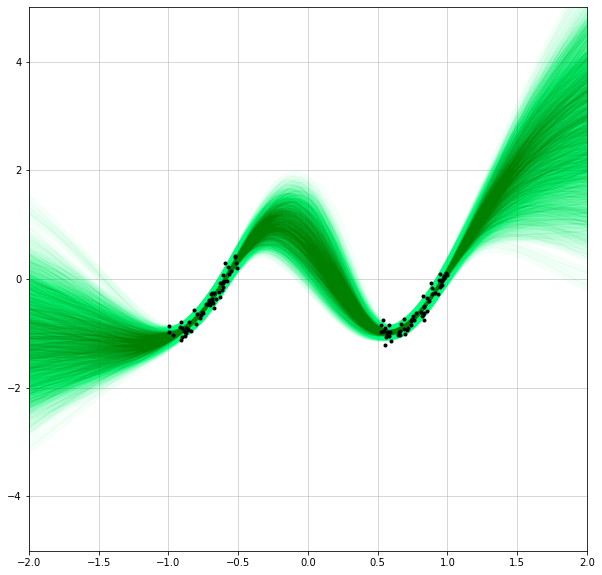

In [5]:
fig=setup.makePlot(theta_HMC[0::10],device)


In [5]:
FG=BigGenerator(5,param_count, device).to(device)
FG.load_state_dict(torch.load('mlruns_/41/3121d1a957474e3796f5468359b23af1/artifacts/model.pt')['state_dict'])
theta_FG=FG(sample_size).detach()

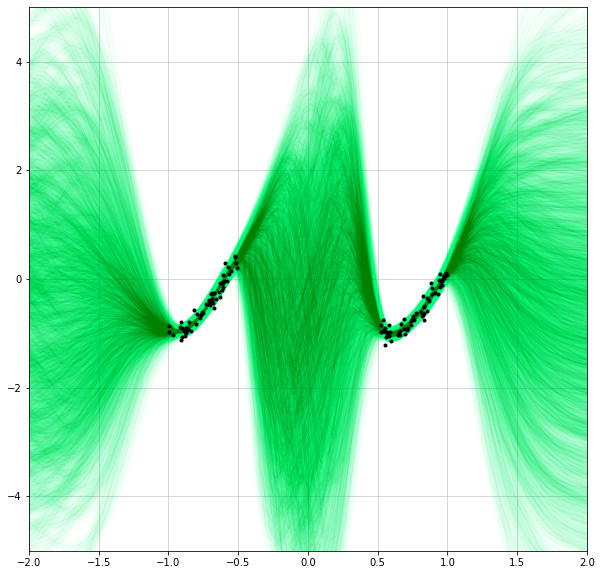

In [9]:
fig=setup.makePlot(FG(1000).detach(),device)

In [6]:
G=BigGenerator(5,param_count, device).to(device)
G.load_state_dict(torch.load('mlruns_/47/d72a89fb327748ee9f893b7aa0a9990f/artifacts/model.pt')['state_dict'])
theta_G=G(sample_size).detach()

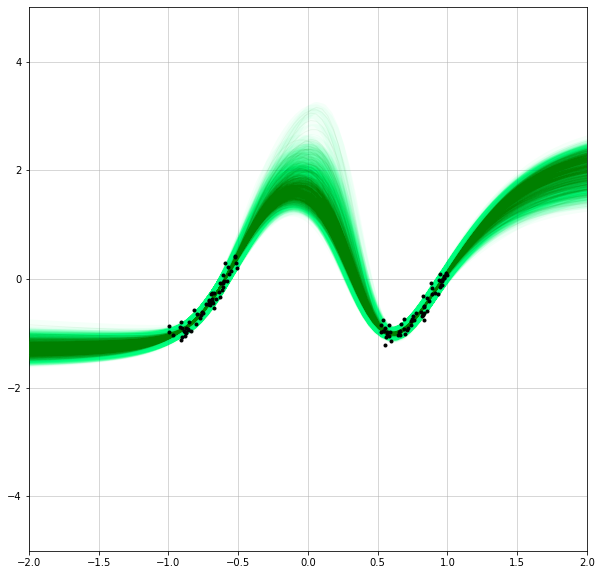

In [11]:
fig=setup.makePlot(G(1000).detach(),device)

In [7]:
models={'HMC':theta_HMC,
        'GeNNeVI':theta_G,
        'FuNNeVI':theta_FG}
for m in models:
    for n in models:
        if not n == m: 
            K=KL(models[m], models[n],k=1,device=device)
            print('KL('+m+','+n+'):'+str(K))

KL(HMC,GeNNeVI):tensor(112.4650, device='cuda:0')
KL(HMC,FuNNeVI):tensor(121.6806, device='cuda:0')
KL(GeNNeVI,HMC):tensor(152.5482, device='cuda:0')
KL(GeNNeVI,FuNNeVI):tensor(168.5419, device='cuda:0')
KL(FuNNeVI,HMC):tensor(522.3702, device='cuda:0')
KL(FuNNeVI,GeNNeVI):tensor(548.6619, device='cuda:0')


In [8]:
import itertools
models_pairs=list(itertools.combinations(models.items(),2))


In [ ]:
print('SW in parameter space')
for (m,s),(n,t) in models_pairs:
        W=sw(s.cpu(), t.cpu(), 'cpu', L=1000)
        print('SW('+m+','+n+'):'+str(W[0])+'('+str(W[1])+')')

In [17]:
def FuKL(t,s,k=1,n=100, m=20):
    assert t.shape == s.shape
    K=torch.Tensor(n)
    for i in range(n):
        t_, s_= projection(t, s, m, 1.)
        K[i]=KL(t_, s_, k=k,device=device)
    return K.mean()
print('KL in function space L_2([-2,2])')
for (m,s),(n,t) in models_pairs:
        K=FuKL(s, t)
        K_=FuKL(t,s)
        print('KL('+m+','+n+'):'+str(K.item())+'   '+'KL('+n+','+m+'):'+str(K_.item()) )
        print('J('+m+','+n+'):'+str(0.5*(K.item()+K_.item())))

KL in function space L_2([-2,2])
KL(HMC,GeNNeVI):40.83565902709961   KL(GeNNeVI,HMC):36.91374588012695
J(HMC,GeNNeVI):38.87470245361328
KL(HMC,FuNNeVI):33.89963912963867   KL(FuNNeVI,HMC):32.77749252319336
J(HMC,FuNNeVI):33.338565826416016
KL(GeNNeVI,FuNNeVI):56.068782806396484   KL(FuNNeVI,GeNNeVI):41.23732376098633
J(GeNNeVI,FuNNeVI):48.653053283691406


In [20]:
def FunSW(t,s, n=10, m=20, L=1000):
    assert t.shape == s.shape
    W=torch.Tensor(n)
    for i in range(n):
        t_, s_= projection(t, s, m , 1.)
        W[i]=sw(s_.cpu(), t_.cpu(),'cpu', L=L)[0]
    return W.mean(), W.std()

print('Sliced Wasserstein in function space L_2([-2,2])')
for (m,s),(n,t) in models_pairs:
    W=FunSW(s,t)
    print('SW('+m+','+n+'):'+str(W[0].item())+'('+str(W[1].item())+')')


Sliced Wasserstein in function space L_2([-2,2])
SW(HMC,GeNNeVI):tensor(0.3002)(tensor(0.0622))
SW(HMC,FuNNeVI):tensor(1.1931)(tensor(0.2134))
SW(GeNNeVI,FuNNeVI):tensor(1.1555)(tensor(0.1658))


# Testing variance of the metric FuKL #

In [20]:
K=[FuKL(models['FuNNeVI'],models['HMC']).cpu().numpy() for _ in range(100)]


In [21]:
np.mean(K),np.std(K)

(32.60011, 0.18004113)

# Predictive metrics #

In [54]:
import scipy.stats as st

def pred_div(s,t,X):
    J=torch.Tensor(X.shape[0])
    K=torch.Tensor(X.shape[0])
    K_=torch.Tensor(X.shape[0])
    W=torch.Tensor(X.shape[0])
    for x in range(X.shape[0]):
        K[x]=KL(s[:,x].unsqueeze(-1),t[:,x].unsqueeze(-1),k=300)
        K_[x]=KL(t[:,x].unsqueeze(-1),s[:,x].unsqueeze(-1),k=300)
        W[x]=st.wasserstein_distance(s[:,x].cpu().numpy(),t[:,x].cpu().numpy())
    J=0.5*(K+K_)
    return [K, K_, J, W]

In [55]:
X=torch.linspace(-2,2,100).to(device)
t=model(X,models['HMC']).squeeze()
s=model(X,models['GeNNeVI']).squeeze()
metrics_GE=pred_div(s,t,X)

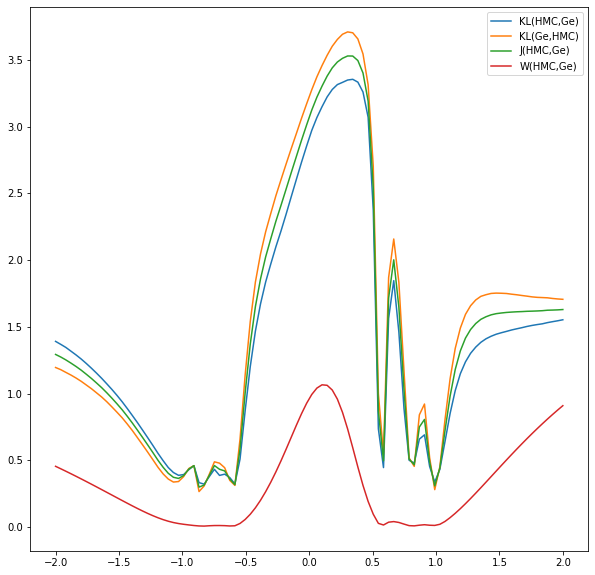

In [65]:
plt.subplots(figsize=(10,10))
for m in metrics_GE:
    plt.plot(X.cpu(),m.cpu())
plt.legend(['KL(HMC,Ge)','KL(Ge,HMC)','J(HMC,Ge)', 'W(HMC,Ge)'])


In [66]:
X=torch.linspace(-2,2,100).to(device)
t=model(X,models['HMC']).squeeze()
s=model(X,models['FuNNeVI']).squeeze()
metrics_FU=pred_div(s,t,X)

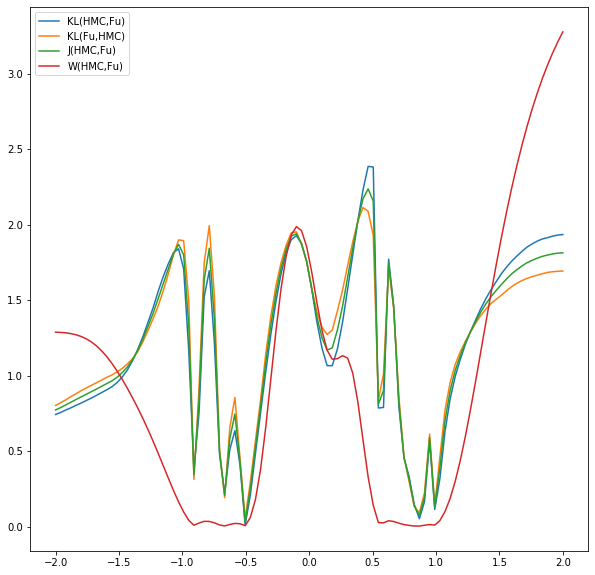

In [69]:
plt.subplots(figsize=(10,10))
for m in metrics_FU:
    plt.plot(X.cpu(),m.cpu())
plt.legend(['KL(HMC,Fu)','KL(Fu,HMC)','J(HMC,Fu)', 'W(HMC,Fu)'])


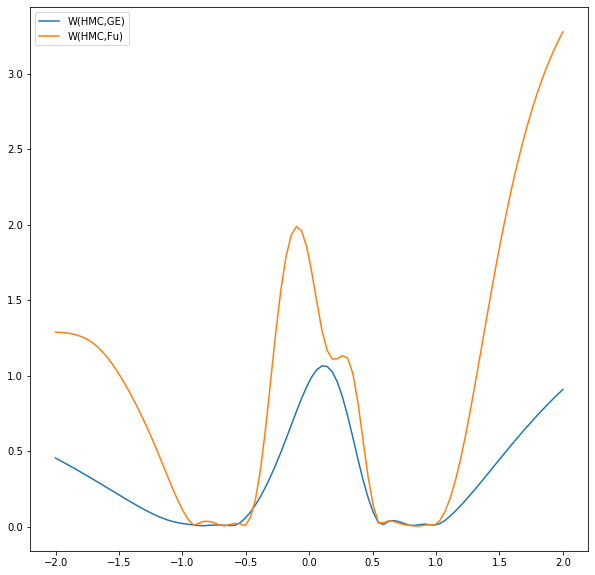

In [70]:
plt.subplots(figsize=(10,10))
plt.plot(X.cpu(),metrics_GE[3].cpu())
plt.plot(X.cpu(),metrics_FU[3].cpu())
plt.legend( ['W(HMC,GE)', 'W(HMC,Fu)'])

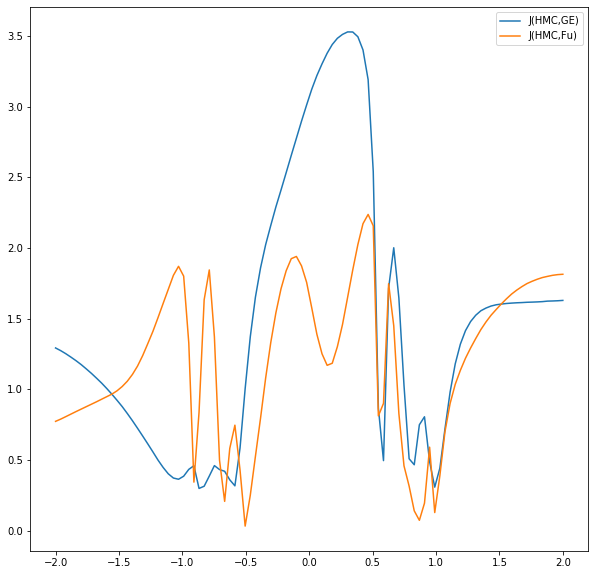

In [71]:
plt.subplots(figsize=(10,10))
plt.plot(X.cpu(),metrics_GE[2].cpu())
plt.plot(X.cpu(),metrics_FU[2].cpu())
plt.legend( ['J(HMC,GE)', 'J(HMC,Fu)'])

# T-sne #

In [15]:
thetas=[theta_HMC,theta_G,theta_FG]
thetas=[t[::10] for t in thetas]

size_sample=thetas[0].shape[0]

theta=torch.cat(thetas,dim=0)
colors=torch.cat([torch.zeros(size_sample),0.1*torch.ones(size_sample),0.2*torch.ones(size_sample)])
theta.shape

torch.Size([3000, 151])

In [16]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=2,init='pca',perplexity=5)
X_embedded_ =myTSNE.fit_transform(theta.cpu())
print(myTSNE.kl_divergence_)
X_embedded_.shape

1.8272266387939453


(3000, 2)

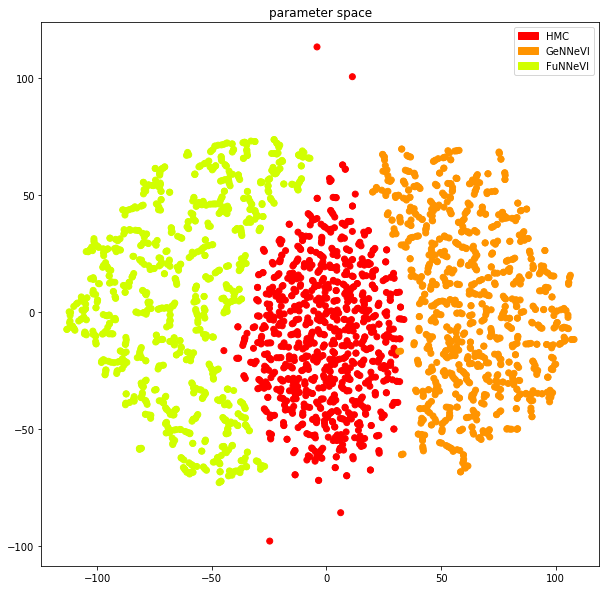

In [19]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.patches as mpatches

import matplotlib.cm as cm
cmap = cm.hsv


fig = plt.figure(figsize=(10, 10))




G1_patch = mpatches.Patch(color=cmap(0.), label='HMC')
G2_patch = mpatches.Patch(color=cmap(0.1), label='GeNNeVI')
G3_patch = mpatches.Patch(color=cmap(0.2), label='FuNNeVI')



#ax = fig.gca(projection='3d')
plt.scatter(X_embedded_[:,0],X_embedded_[:,1],color=cmap(colors),cmap=cmap) #,X_embedded_[:,2]
#plt.title('3D t-SNE of '+str(param_count)+'-dimensional transformed noise')
#ax.view_init(elev=20., azim=270)

plt.legend(handles=[G1_patch,G2_patch,G3_patch])
plt.title('parameter space')
plt.show()


In [20]:
X=torch.linspace(-2,2,100).to(device)
thetas_proj=[model(X,t).squeeze() for t in thetas]
theta_proj=torch.cat(thetas_proj,dim=0)


In [25]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=2,init='pca',perplexity=50)
X_embedded_proj =myTSNE.fit_transform(theta_proj.cpu())
print(myTSNE.kl_divergence_)
X_embedded_.shape

0.9328190684318542


(3000, 2)

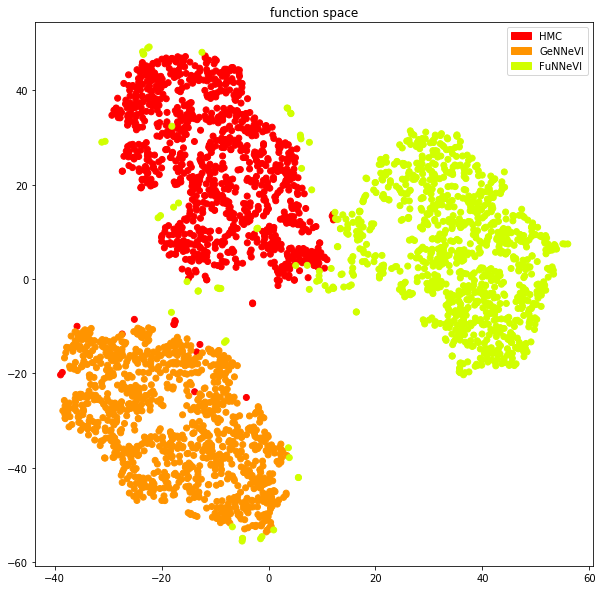

In [26]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.patches as mpatches

import matplotlib.cm as cm
cmap = cm.hsv


fig = plt.figure(figsize=(10, 10))



G1_patch = mpatches.Patch(color=cmap(0.), label='HMC')
G2_patch = mpatches.Patch(color=cmap(0.1), label='GeNNeVI')
G3_patch = mpatches.Patch(color=cmap(0.2), label='FuNNeVI')


#ax = fig.gca(projection='3d')
plt.scatter(X_embedded_proj[:,0],X_embedded_proj[:,1],color=cmap(colors),cmap=cmap) #,X_embedded_[:,2]
#plt.title('3D t-SNE of '+str(param_count)+'-dimensional transformed noise')
#ax.view_init(elev=20., azim=270)

plt.legend(handles=[G1_patch,G2_patch,G3_patch])
plt.title('function space')
plt.show()
